In [1]:
import cv2
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from tqdm import tqdm
import os

RSEED = 42

In [2]:
# get path to the data folder
DATA_DIR = Path.cwd().parent.resolve() / "data"
assert DATA_DIR.exists()

MODEL_DIR = Path.cwd()

In [3]:
def replace_nan(x):
    if x=="nan":
        return np.nan
    else :
        return float(x)

def convert_str_to_list(data, features):
    for feature in features : 
        data[feature]=data[feature].apply(lambda x: [ replace_nan(X) for X in x.strip('[]').split(",")])
    return data

## Data cleaning 

In [4]:
# read dataset from csv file
df = pd.read_csv(DATA_DIR / "dataset_all_feat_with_radiation.csv", parse_dates=["date"])
df = convert_str_to_list(df, ['temp', 'wind', 'radiation'])
# add day of the year as additional feature
df['dayofyear'] = df['date'].dt.dayofyear
df.head()

,uid,latitude,longitude,date,split,region,severity,density,image_src,lake_size,...,mean_s,mean_v,temp,wind,elev_mean,elev_median,elev_min,elev_max,radiation,dayofyear
0,aabm,39.080319,-86.430867,2018-05-14,train,midwest,1,585.0,sentinel,2578.0,...,0.234153,0.607841,"[286.6784, 286.74725, 286.69934, 286.7568, 286...","[2.2833447, 1.94622, 1.331817, 1.2656376, 2.75...",0.058860,0.057391,0.057125,0.068623,"[0.0, 994.0, 948.0, 0.0, 391.0, 905.0, 0.0, 96...",134
1,aacd,35.875083,-78.878434,2020-11-19,train,south,1,290.0,sentinel,176.0,...,0.503357,0.115065,"[290.66895, 286.5667, 285.7143, 291.8991, 285....","[2.005445, 3.5083356, 2.3487167, 2.2689152, 1....",0.044726,0.044747,0.039996,0.048706,"[0.0, 380.8, 393.0, 0.0, 558.1, 492.2, 0.0, 11...",324
2,aaee,35.487000,-79.062133,2016-08-24,train,south,1,1614.0,no_image,NaN,...,NaN,NaN,"[301.63077, nan, nan, 314.93414, 301.9608, 297...","[1.5693433, nan, nan, 6.309602, 1.4112688, 2.9...",0.050598,0.050579,0.043481,0.056447,"[0.0, 473.0, 875.0, 0.0, 938.0, 868.0, 0.0, 80...",237
3,aaff,38.049471,-99.827001,2019-07-23,train,midwest,3,111825.0,sentinel,1495.0,...,0.480389,0.085137,"[306.29938, 298.71417, 300.36365, 315.71246, 3...","[7.8561816, 6.940431, 7.351467, 10.175036, 9.9...",0.174059,0.173836,0.171177,0.178763,"[129.4, 975.0, 990.0, 128.7, 972.0, 987.0, 129...",204
4,aafl,39.474744,-86.898353,2021-08-23,train,midwest,4,2017313.0,sentinel,8045.0,...,0.412104,0.276187,"[296.7477, 293.41278, 295.93585, 310.729, 298....","[1.9160693, 1.9174393, 1.1719533, 2.0773518, 1...",0.066571,0.065109,0.065109,0.078415,"[0.0, 836.0, 763.0, 0.0, 679.0, 651.0, 0.0, 67...",235


In [5]:
# use only data points after 2014-10-07 because of missing weather data
df = df[df['date'] > datetime.datetime(2014,10,7)]

# reduce dataset to only datapoints where images were found
#df = df[df['image_src'] != 'no_image']

In [6]:
# only 6176 datapoints contain image features (there are no images for the others)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14502 entries, 0 to 17052
Data columns (total 25 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   uid          14502 non-null  object        
 1   latitude     14502 non-null  float64       
 2   longitude    14502 non-null  float64       
 3   date         14502 non-null  datetime64[ns]
 4   split        14502 non-null  object        
 5   region       14502 non-null  object        
 6   severity     14502 non-null  int64         
 7   density      14502 non-null  float64       
 8   image_src    14502 non-null  object        
 9   lake_size    6158 non-null   float64       
 10  mean_r       6158 non-null   float64       
 11  mean_g       6158 non-null   float64       
 12  mean_b       6158 non-null   float64       
 13  mean_ir      6158 non-null   float64       
 14  mean_h       6158 non-null   float64       
 15  mean_s       6158 non-null   float64       
 16  mean

## Modeling
### Data Cleaning and aggregation

In [7]:
df.columns

Index(['uid', 'latitude', 'longitude', 'date', 'split', 'region', 'severity',
       'density', 'image_src', 'lake_size', 'mean_r', 'mean_g', 'mean_b',
       'mean_ir', 'mean_h', 'mean_s', 'mean_v', 'temp', 'wind', 'elev_mean',
       'elev_median', 'elev_min', 'elev_max', 'radiation', 'dayofyear'],
      dtype='object')

In [8]:
example_row = df[df.uid == "garm"].iloc[0]

# drop one extreme outlier
#outlier = df[df.uid == "lvtt"].iloc[0]
df = df.drop(df.loc[df['uid']=='lvtt'].index)

df = df.reset_index(drop=True)

In [9]:
# this takes 2min 58sec to execute:

# # calculate daily mean values for temperature and wind
# days = range(7)
# for row in (pbar := tqdm(df.itertuples(), total=len(df))):
#     for day in days:
#         # get daily wind means
#         mean_wind = np.nanmean([row.wind[4*(day+1)-4], 
#                                 row.wind[4*(day+1)-3], 
#                                 row.wind[4*(day+1)-2], 
#                                 row.wind[4*(day+1)-1]])
#         df.loc[df['uid'] == row.uid, [f'wind_mean_{day+1}']] = mean_wind
#         # get daily temp means
#         mean_temp = np.nanmean([row.temp[4*(day+1)-4],
#                                 row.temp[4*(day+1)-3], 
#                                 row.temp[4*(day+1)-2], 
#                                 row.temp[4*(day+1)-1]])
#         df.loc[df['uid'] == row.uid, [f'temp_mean_{day+1}']] = mean_temp

In [10]:
# this takes 3.8sec to execute:

# function to calculate daily mean values from a time series with 4 values per day
def get_daily_means(time_series, num_daily_values=4):
    length = len(time_series)//num_daily_values
    means = np.zeros(length)
    for i in range(length):
        means[i] = np.nanmean(time_series[i * num_daily_values : (i+1) * num_daily_values])
    return means

# calculate daily means for all weather features and add them as 
# new columns to the dataframe.
weather_feats = ['temp', 'wind']
for feat in weather_feats:
    df[f'{feat}_daily'] = df[feat].apply(get_daily_means)
    df_new = df[f'{feat}_daily'].apply(pd.Series)
    df_new.columns = [f'{feat}_mean_{i+1}' for i in range(7)]
    df = df.merge(df_new, left_index=True, right_index=True, how='inner')
    df = df.drop(f'{feat}_daily', axis=1)

/var/folders/x6/y83h9zms7bq9mpq4000kg4tc0000gn/T/ipykernel_54409/2443253084.py:8: RuntimeWarning: Mean of empty slice
  means[i] = np.nanmean(time_series[i * num_daily_values : (i+1) * num_daily_values])


In [11]:
df.head()

,uid,latitude,longitude,date,split,region,severity,density,image_src,lake_size,...,temp_mean_5,temp_mean_6,temp_mean_7,wind_mean_1,wind_mean_2,wind_mean_3,wind_mean_4,wind_mean_5,wind_mean_6,wind_mean_7
0,aabm,39.080319,-86.430867,2018-05-14,train,midwest,1,585.0,sentinel,2578.0,...,287.278008,287.331322,287.371427,1.706755,3.075927,4.024818,2.873090,4.981789,3.556102,3.439010
1,aacd,35.875083,-78.878434,2020-11-19,train,south,1,290.0,sentinel,176.0,...,281.520655,279.392285,277.597368,2.532853,1.657363,2.778842,2.605776,3.004587,2.302050,1.371255
2,aaee,35.487000,-79.062133,2016-08-24,train,south,1,1614.0,no_image,NaN,...,301.466250,293.931750,296.775000,3.939473,1.808803,2.279739,4.535705,4.829182,1.861201,1.717719
3,aaff,38.049471,-99.827001,2019-07-23,train,midwest,3,111825.0,sentinel,1495.0,...,304.939147,300.523025,298.255080,8.080779,8.766938,8.050130,8.660211,5.739048,5.417003,2.800415
4,aafl,39.474744,-86.898353,2021-08-23,train,midwest,4,2017313.0,sentinel,8045.0,...,300.945415,300.772760,302.143397,1.770703,1.297279,1.610505,1.468337,2.284808,1.152128,2.028960


In [12]:
# mean temperature and wind over the whole time (7 days)
df['temp_mean'] = df["temp"].apply(np.nanmean)
df['wind_mean'] = df["wind"].apply(np.nanmean)
df['rad_mean'] = df["radiation"].apply(np.nanmean)

In [13]:
df.columns

Index(['uid', 'latitude', 'longitude', 'date', 'split', 'region', 'severity',
       'density', 'image_src', 'lake_size', 'mean_r', 'mean_g', 'mean_b',
       'mean_ir', 'mean_h', 'mean_s', 'mean_v', 'temp', 'wind', 'elev_mean',
       'elev_median', 'elev_min', 'elev_max', 'radiation', 'dayofyear',
       'temp_mean_1', 'temp_mean_2', 'temp_mean_3', 'temp_mean_4',
       'temp_mean_5', 'temp_mean_6', 'temp_mean_7', 'wind_mean_1',
       'wind_mean_2', 'wind_mean_3', 'wind_mean_4', 'wind_mean_5',
       'wind_mean_6', 'wind_mean_7', 'temp_mean', 'wind_mean', 'rad_mean'],
      dtype='object')

In [14]:
# all of the features are numerical

# features = ['latitude', 'longitude', 'lake_size', 'mean_r', 'mean_g', 'mean_b',
#        'mean_ir', 'mean_h', 'mean_s', 'mean_v', 'elev_mean',
#        'elev_median', 'elev_min', 'elev_max', 'dayofyear', 'wind_mean_1',
#        'temp_mean_1', 'wind_mean_2', 'temp_mean_2', 'wind_mean_3',
#        'temp_mean_3', 'wind_mean_4', 'temp_mean_4', 'wind_mean_5',
#        'temp_mean_5', 'wind_mean_6', 'temp_mean_6', 'wind_mean_7',
#        'temp_mean_7', 'temp_mean', 'wind_mean', 'rad_mean']

features = ['latitude', 'longitude', 'lake_size', 'mean_ir', 'mean_h', 'elev_mean', 
            'dayofyear', 'temp_mean', 'wind_mean', 'rad_mean']

#features = ['lake_size', 'mean_ir', 'mean_h', 'elev_mean', 'temp_mean', 'wind_mean']

In [15]:
df[features]

,latitude,longitude,lake_size,mean_ir,mean_h,elev_mean,dayofyear,temp_mean,wind_mean,rad_mean
0,39.080319,-86.430867,2578.0,0.424409,0.413782,0.058860,134,287.095532,3.379642,497.380952
1,35.875083,-78.878434,176.0,0.059888,0.163396,0.044726,324,283.980500,2.321818,300.347619
2,35.487000,-79.062133,NaN,NaN,NaN,0.050598,237,301.782546,3.098980,400.500000
3,38.049471,-99.827001,1495.0,0.020998,0.245394,0.174059,204,304.010039,6.787789,689.352381
4,39.474744,-86.898353,8045.0,0.127355,0.356467,0.066571,235,300.552303,1.658960,490.904762
...,...,...,...,...,...,...,...,...,...,...
14496,38.707825,-75.080867,11.0,0.631636,0.292073,0.022901,178,296.495993,4.426296,384.571429
14497,35.794000,-79.015368,NaN,NaN,NaN,0.035818,218,304.505577,3.595913,610.333333
14498,39.792190,-99.971050,8804.0,0.051426,0.336928,0.173784,170,291.637065,4.246976,706.742857
14499,35.794000,-79.012551,NaN,NaN,NaN,0.035874,83,286.046483,3.574775,482.666667


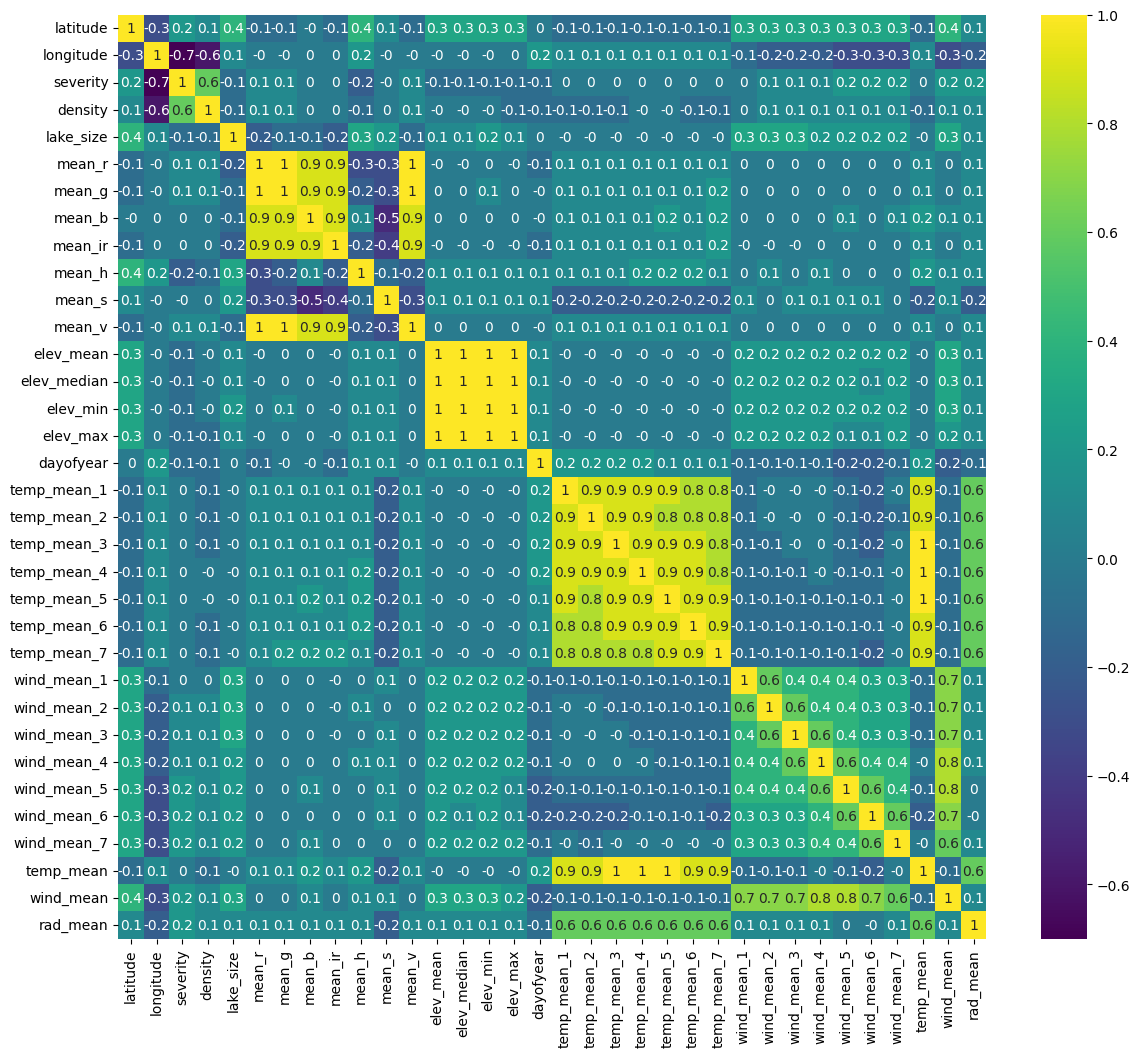

In [16]:
# Plot correlation matrix 
mask = np.triu(df.corr())
plt.figure(figsize = (14,12))
ax = sns.heatmap(round(df.corr(), 1)
                 ,annot=True
                 #,mask=mask
                 ,cmap='viridis')

### train test split

In [17]:
X = df[features]
y = df['severity'] - 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = RSEED)

### Imputing missing values

In [18]:
df[features].isna().sum()

latitude        0
longitude       0
lake_size    8343
mean_ir      8343
mean_h       8343
elev_mean       0
dayofyear       0
temp_mean       0
wind_mean       0
rad_mean        0
dtype: int64

In [19]:
# impute missing values with mean values of train dataset
for feature in features:
    mean = np.nanmean(X_train[feature])
    X_train[feature].fillna(mean, inplace=True)
    X_test[feature].fillna(mean, inplace=True)

### Normalization

In [20]:
# normalize features (esp. 'latitude', 'longitude', 'lake_size', 'dayofyear')
scaler = StandardScaler()
X_train[features] = scaler.fit_transform(X_train[features])
X_test[features] = scaler.transform(X_test[features])

### (small) Baseline model

In [21]:
# Baseline model is just using one feature: 'longitude'
# EDA says longitude has strongest correlation with bacteria density
log_reg = LogisticRegression()
log_reg.fit(X_train[['longitude']], y_train)

LogisticRegression()

In [22]:
log_reg.intercept_

array([ 1.45856366,  0.92404179,  0.99063806, -0.47105142, -2.9021921 ])

<AxesSubplot:xlabel='longitude', ylabel='severity'>

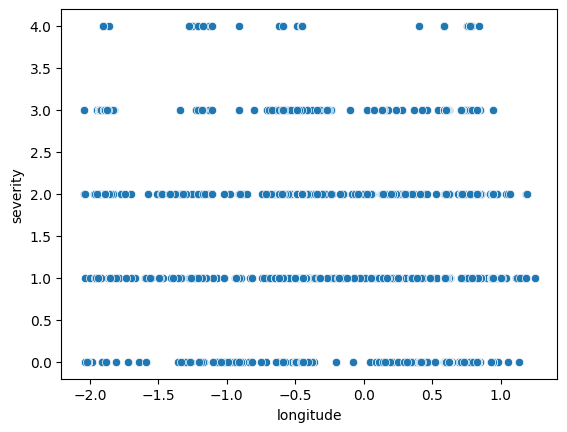

In [23]:
# plot datapoints for mean wind speed and the baseline model
sns.scatterplot(x=X_train['longitude'], y=y_train)

### We need mooore models!!!

In [24]:
def train_predict_evaluate(model, X_train, y_train, X_test, y_test):
    """Train model, make prediction and evaluate

    Args:
        model (_type_): Regressor model
        X_train (_type_): Train data features
        y_train (_type_): Train data target
        X_test (_type_): Test data features
        y_test (_type_): Test data target
    """
    # train model
    model.fit(X_train, y_train)

    # make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # print metrics of predictions
    print(f"Model: {type(model)}") 
    print(f"RMSE on train data: {mean_squared_error(y_train, y_train_pred, squared=False)}")
    print(f"RMSE on test data: {mean_squared_error(y_test, y_test_pred, squared=False)}")
    print('-----------------------------')

In [25]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [26]:
model_dectree     = DecisionTreeClassifier(max_features=6, max_depth=20, criterion='gini', random_state=RSEED)
model_adaboost    = AdaBoostClassifier(random_state=RSEED)
model_svc         = SVC()
model_sgdc        = SGDClassifier(random_state=RSEED)
model_rfc         = RandomForestClassifier(random_state=RSEED)
model_knc         = KNeighborsClassifier()
model_xgbc        = XGBClassifier()

models = [model_dectree, model_adaboost, model_svc, model_sgdc, model_rfc, model_knc, model_xgbc]

for model in tqdm(models):
    train_predict_evaluate(model, X_train, y_train, X_test, y_test)

  0%|          | 0/7 [00:00<?, ?it/s]

Model: <class 'sklearn.tree._classes.DecisionTreeClassifier'>
RMSE on train data: 0.45438476783600407
RMSE on test data: 0.8738019325364175
-----------------------------


 29%|██▊       | 2/7 [00:00<00:01,  3.45it/s]

Model: <class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'>
RMSE on train data: 0.9311190893868999
RMSE on test data: 0.9349766397013963
-----------------------------


 43%|████▎     | 3/7 [00:09<00:14,  3.74s/it]

Model: <class 'sklearn.svm._classes.SVC'>
RMSE on train data: 0.8667219257361176
RMSE on test data: 0.8610856282345075
-----------------------------
Model: <class 'sklearn.linear_model._stochastic_gradient.SGDClassifier'>
RMSE on train data: 1.0046014821465448
RMSE on test data: 1.0003446493295505
-----------------------------


 71%|███████▏  | 5/7 [00:11<00:04,  2.27s/it]

Model: <class 'sklearn.ensemble._forest.RandomForestClassifier'>
RMSE on train data: 0.022742941307367103
RMSE on test data: 0.810139126960763
-----------------------------


 86%|████████▌ | 6/7 [00:11<00:01,  1.74s/it]

Model: <class 'sklearn.neighbors._classification.KNeighborsClassifier'>
RMSE on train data: 0.7665417189537381
RMSE on test data: 0.8734073504740595
-----------------------------


100%|██████████| 7/7 [00:13<00:00,  1.98s/it]

Model: <class 'xgboost.sklearn.XGBClassifier'>
RMSE on train data: 0.548587527986254
RMSE on test data: 0.7868270859284381
-----------------------------


## Hyperparameter tuning (with the best types of models)

In [27]:
def grid_search_evaluate(model, hyperparameters, X_train, y_train, X_test, y_test):
    """make grid search for model parameters, get the best estimator, make prediction and evaluate

    Args:
        model (_type_): Regressor model
        hyperparameters (_type_): parameter list for the grid search
        X_train (_type_): Train data features
        y_train (_type_): Train data target
        X_test (_type_): Test data features
        y_test (_type_): Test data target
    """
    
    gs = GridSearchCV(model, hyperparameters, n_jobs=-1, scoring='accuracy', cv=3, verbose = 0)

    # Fit the grid search object to the training data and find the optimal parameters
    gs.fit(X_train, y_train)

    best_model = gs.best_estimator_

    # make predictions
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    # print metrics of predictions
    print(f"Model: {type(best_model)}") 
    print(f"RMSE on train data: {mean_squared_error(y_train, y_train_pred, squared=False)}")
    print(f"RMSE on test data: {mean_squared_error(y_test, y_test_pred, squared=False)}")
    print('-----------------------------')

    return best_model

In [28]:
model_sgdc = SGDClassifier(random_state=RSEED)
model_svc  = SVC()
model_rfc  = RandomForestClassifier(random_state=RSEED)
model_knc  = KNeighborsClassifier()
model_xgbc = XGBClassifier()

models = [model_sgdc, model_svc, model_rfc, model_knc, model_xgbc]

# parameter lists for tuning
parameters_sgdc = {
                'eta0': [0.01, 0.1],
                'learning_rate':['constant', 'optimal', 'invscaling', 'adaptive'],                
                'max_iter':[500, 1000, 2000]
                } 
parameters_svc = {
                'class_weight': ['balanced', None],
                'C': [0.9, 1.0, 1.1],
                'degree': [2, 3, 4, 5]
                } 
parameters_rfc = {
                'n_estimators':[90, 95, 100],                
                'max_features':[10, 8, 7, 6],               
                'max_depth' : [35, 100], 
                'min_samples_split': [2,4,6]
                } 
parameters_knc = {
                'n_neighbors':[5, 10, 15],                
                'metric':['euclidean', 'manhattan'],               
                'weights':['uniform', 'distance'],                         
                } 
parameters_xgbc = {
                'eta': [0.1, 0.3, 0.5],
                'max_depth': [4, 6, 8],
                'eval_metric': [accuracy_score]
                }

params = [parameters_sgdc, parameters_svc, parameters_rfc, parameters_knc, parameters_xgbc]

best_models = []
for model, param in zip(tqdm(models), params):
    best_models.append(grid_search_evaluate(model, param, X_train, y_train, X_test, y_test))

for model in best_models:
    print(model, '\n', model.get_params(), '\n')


 20%|██        | 1/5 [00:03<00:12,  3.15s/it]

Model: <class 'sklearn.linear_model._stochastic_gradient.SGDClassifier'>
RMSE on train data: 1.010163865163845
RMSE on test data: 0.9968927941457137
-----------------------------


 40%|████      | 2/5 [00:47<01:22, 27.58s/it]

Model: <class 'sklearn.svm._classes.SVC'>
RMSE on train data: 0.8636829718490859
RMSE on test data: 0.8592823055677573
-----------------------------


 60%|██████    | 3/5 [02:47<02:19, 69.55s/it]

Model: <class 'sklearn.ensemble._forest.RandomForestClassifier'>
RMSE on train data: 0.3963192722001308
RMSE on test data: 0.7892329561562129
-----------------------------


/Users/markus/neuefische/tick-tick-bloom/.venv/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/markus/neuefische/tick-tick-bloom/.venv/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be elimina

Model: <class 'sklearn.neighbors._classification.KNeighborsClassifier'>
RMSE on train data: 0.8414376039726953
RMSE on test data: 0.859883833331708
-----------------------------


100%|██████████| 5/5 [03:13<00:00, 38.63s/it]

Model: <class 'xgboost.sklearn.XGBClassifier'>
RMSE on train data: 0.7998922341208824
RMSE on test data: 0.8321777579048031
-----------------------------
SGDClassifier(eta0=0.01, learning_rate='constant', max_iter=500,
              random_state=42) 
 {'alpha': 0.0001, 'average': False, 'class_weight': None, 'early_stopping': False, 'epsilon': 0.1, 'eta0': 0.01, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'constant', 'loss': 'hinge', 'max_iter': 500, 'n_iter_no_change': 5, 'n_jobs': None, 'penalty': 'l2', 'power_t': 0.5, 'random_state': 42, 'shuffle': True, 'tol': 0.001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False} 

SVC(C=1.1, degree=2) 
 {'C': 1.1, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False} 

RandomForestClassifier(max_depth=35, m

### Test the model

In [29]:
best_model = best_models[2]

y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

print(f"RMSE on train data: {mean_squared_error(y_train, y_train_pred, squared=False)}")
print(f"RMSE on test data: {mean_squared_error(y_test, y_test_pred, squared=False)}")

RMSE on train data: 0.3963192722001308
RMSE on test data: 0.7892329561562129


Accuracy:  0.6546018614270941
F1-Score:  0.6489257296276096


Text(0.5, 1.0, 'Confusion Matrix')

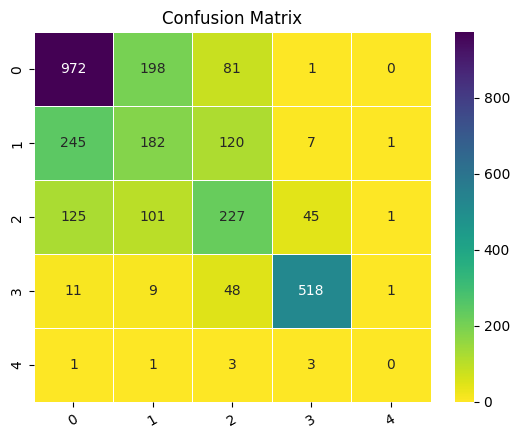

In [30]:
cm = confusion_matrix(y_test, y_test_pred,)
#print(f"RMSE on test data: {mean_squared_error(y_test, y_test_pred, squared=False)}")
print("Accuracy: ", accuracy_score(y_test, y_test_pred))
print("F1-Score: ", f1_score(y_test, y_test_pred, average='weighted'))

sns.heatmap(cm, cmap='viridis_r', annot=True, fmt='d', linewidths=.5,);
plt.xticks(rotation=30, ha='right', rotation_mode='anchor')
plt.title('Confusion Matrix')

In [31]:
def feature_plot(importances, X_train, y_train, num_features=6):
    # Display the n most important features
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:num_features]]
    values = importances[indices][:num_features]
    # Create the plot
    fig = plt.figure(figsize = (9,6))
    #plt.title(f"Most important features using only data points with sat images", fontsize=16)
    plt.title(f"Most important features", fontsize=16)
    plt.bar(np.arange(num_features),
            values, 
            width=0.5, 
            align="center", 
            color='#0a3d42',
            label="Feature Weight")
    plt.bar(np.arange(num_features) - 0.3, 
            np.cumsum(values), 
            width=0.3, 
            align="center", 
            color='#239098',
            label="Cumulative Feature Weight")
    features_dict = {
                'latitude':'Latitude',
                'longitude':'Longitude',
                'lake_size':'Lake size',
                'mean_ir':'Infrared',
                'mean_h':'Color Hue',
                'elev_mean':'Elevation',
                'dayofyear':'Day of Year',
                'temp_mean':'Temperature',
                'wind_mean':'Wind Speed',
                'rad_mean':'Radiation'
                }
    plt.xticks(np.arange(num_features), [features_dict[key] for key in columns])
    plt.ylabel("Weight", fontsize=12)
    plt.xlabel("Feature", fontsize=12)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()  

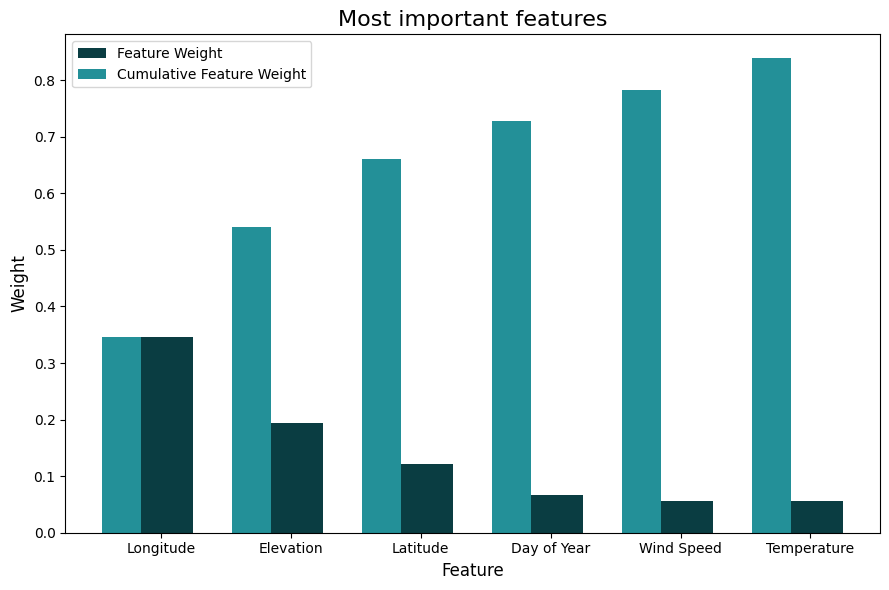

In [32]:
# Extract the feature importances
importances = best_models[2].feature_importances_

# Plot
feature_plot(importances, X_train, y_train)

In [33]:
# # region based RMSE score
# region_scores = []
# for region in val_set.region.unique():
#     sub = val_set[val_set.region == region]
#     region_rmse = mean_squared_error(sub.severity, sub.pred, squared=False)
#     print(f"RMSE for {region} (n={len(sub)}): {round(region_rmse, 4)}")
#     region_scores.append(region_rmse)

# overall_rmse = np.mean(region_scores)
# print(f"Final score: {overall_rmse}")

In [34]:
# # score not based on regions
# mean_squared_error(y_val, val_preds, squared=False)